In [1]:
import torch
import torch.nn as nn
from torchinfo import summary
from tqdm import tqdm

In [2]:
with open("brackets.txt", "r") as f:
    brackets = f.readlines()
idxs = list(map(lambda line: list(map(lambda val: int(val), line.split())), brackets))
idxs = torch.tensor(idxs, dtype=torch.long)
idxs.shape

torch.Size([60000, 64])

In [3]:
train_val_split = 0.8
train_size = int(train_val_split * len(idxs))

train_idxs = idxs[:train_size]
val_idxs = idxs[train_size:]

train_dataset = torch.utils.data.TensorDataset(train_idxs[:, :-1], train_idxs[:, 1:])
val_dataset = torch.utils.data.TensorDataset(val_idxs[:, :-1], val_idxs[:, 1:])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False)

In [4]:
idx_to_char = {
    0: "{",
    1: "(",
    2: "[",
    3: "<",
    4: "}",
    5: ")",
    6: "]",
    7: ">",
    8: "SOS ",
    9: " EOS",
    10: "__"
}
def decode_brackets(brackets):
    brackets = brackets.tolist()
    return "".join([idx_to_char[idx] for idx in brackets])

decode_brackets(idxs[0])

'SOS [<{[[<{{[([[[[<{<<<[({(<<(((<<{}>>)))>>)})]>>>}>]]]])]}}>]]}>] EOS'

In [5]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

@torch.no_grad()
def evaluate(model, data_loader):
    model.eval()
    total_loss = 0
    for inputs, targets in data_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs, loss = model(inputs, targets)
        
        total_loss += loss.item()
    return total_loss / len(data_loader)

In [47]:
class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNCell, self).__init__()
        
        self.hidden_size = hidden_size

        self.Z = nn.Linear(input_size + hidden_size, hidden_size)
        self.R = nn.Linear(input_size + hidden_size, hidden_size)
        self.H_tilde = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, x, h):
        print(x.shape, h.shape)
        z = self.Z(torch.cat([x, h], dim=1))
        r = self.R(torch.cat([x, h], dim=1))
        h_tilde = self.H_tilde(torch.cat([x, r * h], dim=1))
        h = z * h + (1 - z) * h_tilde
        return h, h

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=4):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.ModuleList([RNNCell(hidden_size, hidden_size) for _ in range(num_layers)])
        self.output = nn.Linear(hidden_size, input_size, bias=False)

        self.output.weight = self.embedding.weight

    def forward(self, x, targets=None, h=None):
        if h is None:
            h = torch.zeros(x.size(0), 1, self.hidden_size, device=x.device)

        outputs = []
        loss = torch.tensor(0.0, device=x.device)

        for i in range(x.size(1)):
            x_t = self.embedding(x[:, i])

            for rnn_cell in self.rnn:
                o, h = rnn_cell(x_t, h)

            y_pred = self.output(o)
            outputs.append(y_pred)
            if targets is not None:
                loss += nn.functional.cross_entropy(y_pred, targets[:, i])

        outputs = torch.stack(outputs, dim=1)
        return (outputs) if targets is None else (outputs, loss / x.size(1))
    
    @torch.no_grad()
    def generate(self, x=None, h=None, max_len=10, temperature=1.0):
        if h is None:
            h = torch.zeros(1, self.hidden_size, device=device)
        if x is None:
            x = torch.tensor([[8]], dtype=torch.long, device=device)

        outputs = []
        for i in range(max_len):
            x_t = self.embedding(x)

            for rnn_cell in self.rnn:
                o, h = rnn_cell(x_t, h)
            
            y_pred = self.output(o) / temperature
            y_pred = y_pred.argmax(dim=1)
            outputs.append(y_pred)
            x = y_pred

        outputs = torch.stack(outputs, dim=1)
        return outputs

model = RNN(10, 64).to(device)
# summary(model, (1024, 31), dtypes=[torch.long], device=device)
decode_brackets(model.generate().flatten())

torch.Size([1, 1, 64]) torch.Size([1, 1, 64])


RuntimeError: linear(): input and weight.T shapes cannot be multiplied (2x64 and 128x64)

In [42]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [43]:
if "val_loss" in locals():
    pass
else:
    val_loss = float("inf")

for epoch in range(100):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    for inputs, targets in pbar:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs, loss = model(inputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(loss=loss.item(), val_loss=val_loss)

    val_loss = evaluate(model, val_loader)

Epoch 0:  73%|███████▎  | 137/188 [00:17<00:06,  7.95it/s, loss=1.49, val_loss=1.49]


KeyboardInterrupt: 

In [ ]:
decode_brackets(model.generate(
    x=torch.tensor([[8]], dtype=torch.long, device=device),
    h=torch.randn(1, 64, device=device),
).flatten())

'{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{{'

In [51]:
torch.tensor([[8, 1, 2, 3, 4, 5, 6, 7]], dtype=torch.long, device=device).shape

torch.Size([1, 8])

In [12]:
import matplotlib.pyplot as plt

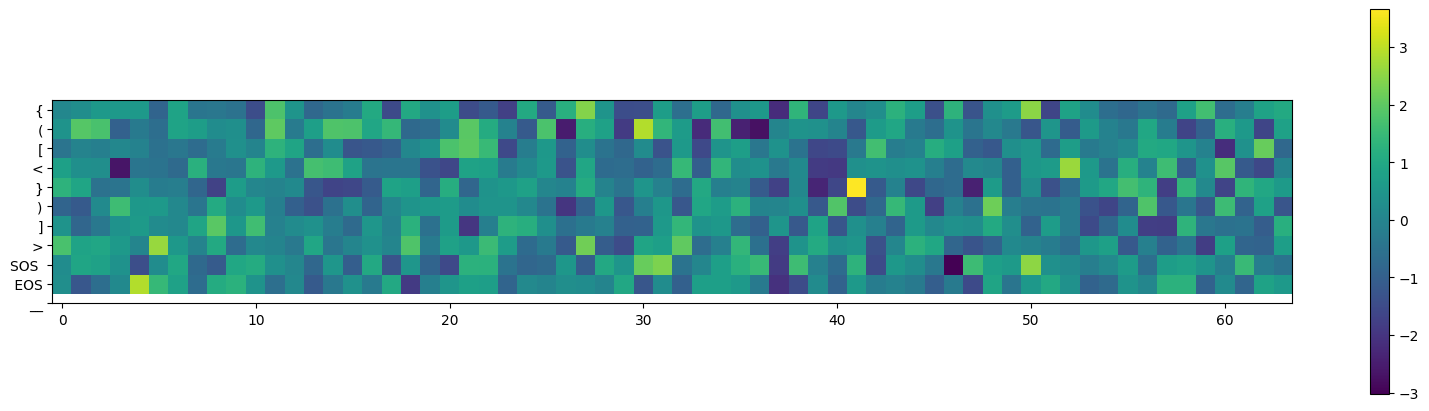

In [25]:
plt.figure(figsize=(20, 5))
plt.imshow(model.embedding.weight.detach().cpu().squeeze().numpy())
plt.yticks(ticks=range(11), labels=[idx_to_char[i] for i in range(11)])
plt.colorbar()
plt.show()